# Exploring ODF Extraction - BP Data Analysis
## Sam Potter
## Current: 5/28/19

## Path and Imports

In [1]:
import sys
import os

# psfdi
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\Github\psfdi',
                 'C:/Users/potterst1/Desktop/Repositories/Github/psfdi'])
sys.path.extend(['/workspace/stpotter/git/github/psfdi'])

from psfdi import visualize
from psfdi import fileIO
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import rc
from psfdi import utilities
from psfdi import odf
from psfdi import image_processing as imp
import seaborn as sns
import cv2
import matplotlib

from ipywidgets import *
from scipy import optimize as sciopt
from scipy.integrate import trapz
from scipy.interpolate import interp1d

## Magics

In [2]:
%matplotlib inline

# Visualize Axis Confirmation Images

In [3]:
if sys.platform == 'linux':
    paper_data_path = '/workspace/stpotter/Data/pSFDI/2D-Biax-Data/4.28.19/3) Paper/Sample/Vertical/Green'
else:
    paper_data_path = 'C:\\Users\\potterst1\\DropBox\\UT\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.28.19\\3) Paper\\Sample\\Vertical\\Green'

paper_pic = cv2.imread(os.path.join(paper_data_path, 'planar_angle_0.tiff'), -1)

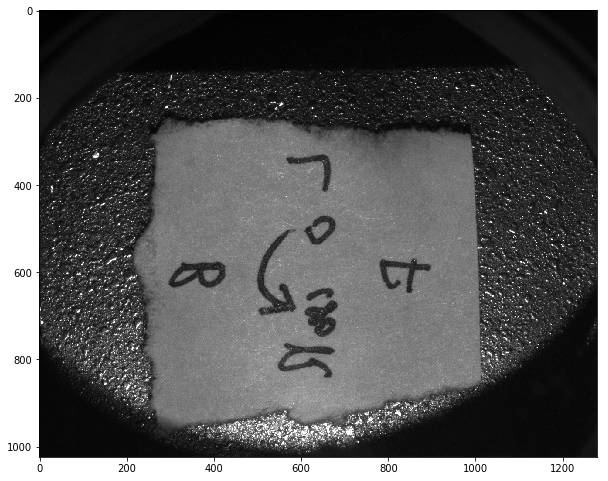

In [4]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(paper_pic, cmap='gray');

# BP Data

## Load Raw Intensity pSFDI Data - 360 Degrees

### Specify file paths

In [5]:
if sys.platform == 'linux':
    bp_raw_path = '/workspace/stpotter/Data/pSFDI/2D-Biax-Data/4.28.19/2) pSFDI/Sample/Vertical/Green'
    bp_standard_path = '/workspace/stpotter/Data/pSFDI/2D-Biax-Data/4.28.19/1) Standard/Sample/Vertical/Green'
else:
    bp_raw_path = 'C:\\Users\\potterst1\\DropBox\\UT\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.28.19\\2) pSFDI\\Sample\\Vertical\\Green'
    bp_standard_path = 'C:\\Users\\potterst1\\DropBox\\UT\\Research\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.28.19\\1) Standard\\Standard\\Vertical\\Green'

### Specify spatial frequency and polarizer resolution

In [6]:
sfx_per = 36.4679
polar_res = 4
polar_max = 360
polar_angles = np.arange(0, polar_max, polar_res)

bp_planar = [cv2.imread(os.path.join(bp_raw_path, 'planar_angle_' + str(angle) + '.tiff'), -1)for angle in polar_angles]
bp_planar = np.array(bp_planar)

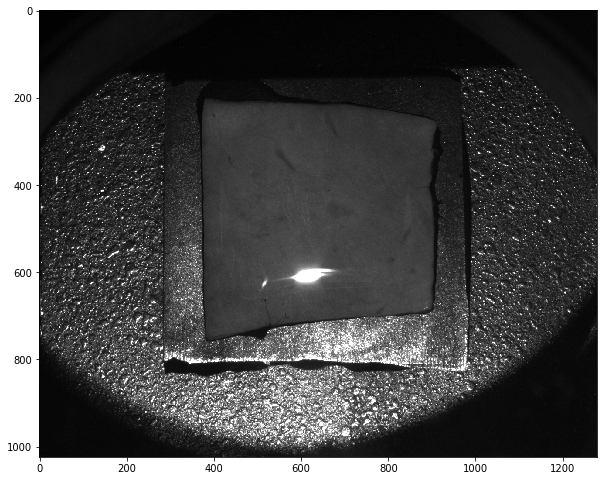

In [7]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(bp_planar[0, :, :], cmap='gray');

## Crop pSFDI ROI - Doing this manually for now

In [8]:
rowstart, rowstop = 175, 775  # Best: 175, 775
colstart, colstop = 350, 925  # Best: 350, 925

bp_planar = bp_planar[:, rowstart:rowstop, colstart:colstop]

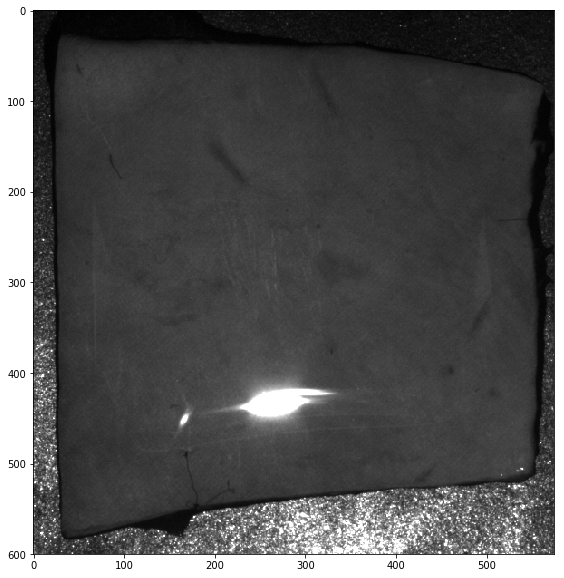

In [9]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(bp_planar[0, :, :], cmap='gray');

## Load in SALS data

In [10]:
if sys.platform == 'linux':
    SALS_data_path = '/workspace/stpotter/Data/pSFDI/SALS/BP ODF 042919'
    SALS_data_dict = fileIO.read_SALS(os.path.join(SALS_data_path, 'SALSA OUT TXT/BP_ODF_42919_SALSA.txt'))
else:
    SALS_data_path = 'C:\\Users\\potterst1\\DropBox\\UT\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\SALS\\BP\\Results\\BP ODF 042919'
    SALS_data_dict = fileIO.read_SALS(os.path.join(SALS_data_path, 'SALSA OUT TXT\\BP_ODF_42919_SALSA.txt'))

In [11]:
if sys.platform == 'linux':
    sals_pd_im = cv2.imread(os.path.join(SALS_data_path, 'Images/BP_ODF_42919_PrefD.png'), -1)
else:
    sals_pd_im = cv2.imread(os.path.join(SALS_data_path, 'Images\\BP_ODF_42919_PrefD.png'), -1)

sals_pd_im = cv2.cvtColor(sals_pd_im, cv2.COLOR_BGR2RGB)

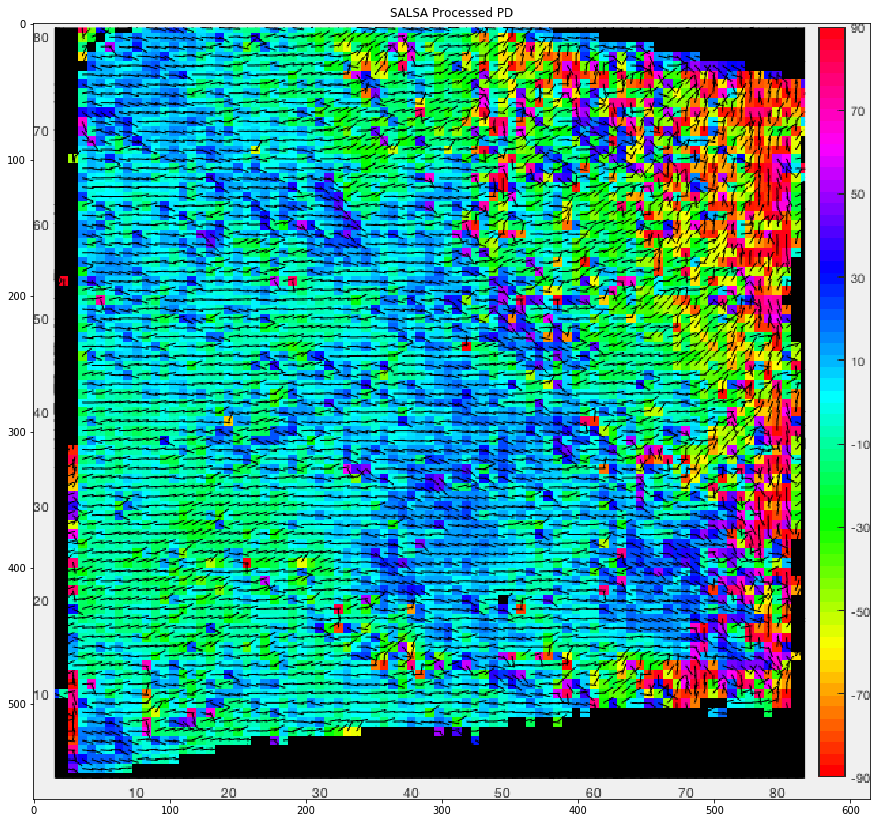

In [12]:
fig = plt.figure(figsize=(15, 15))
plt.title('SALSA Processed PD')
plt.imshow(sals_pd_im);

In [13]:
x = SALS_data_dict['x']
y = SALS_data_dict['y']

PD_2d = SALS_data_dict['PD']
SD_2d = SALS_data_dict['SD']

U = np.cos(np.deg2rad(PD_2d))
V = np.sin(np.deg2rad(PD_2d))

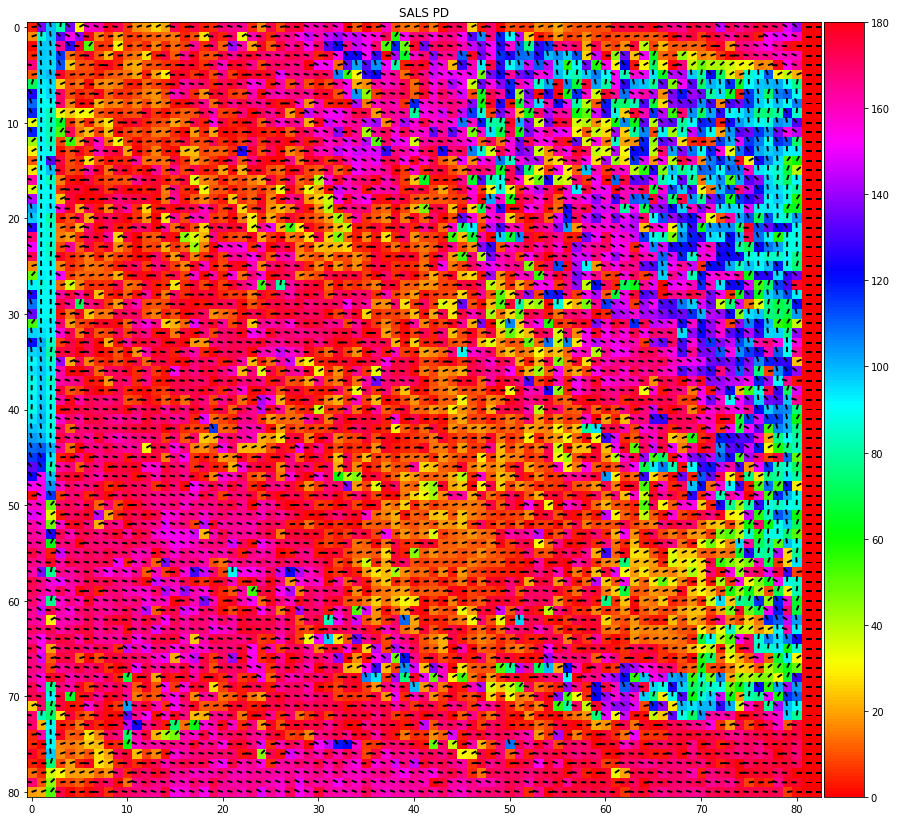

In [14]:
# SALS PD
fig = plt.figure(figsize=(15, 15))
im0 = plt.imshow(PD_2d, cmap='hsv')
plt.quiver(U, V, headlength=0, headaxislength=0);
plt.title('SALS PD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 180);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

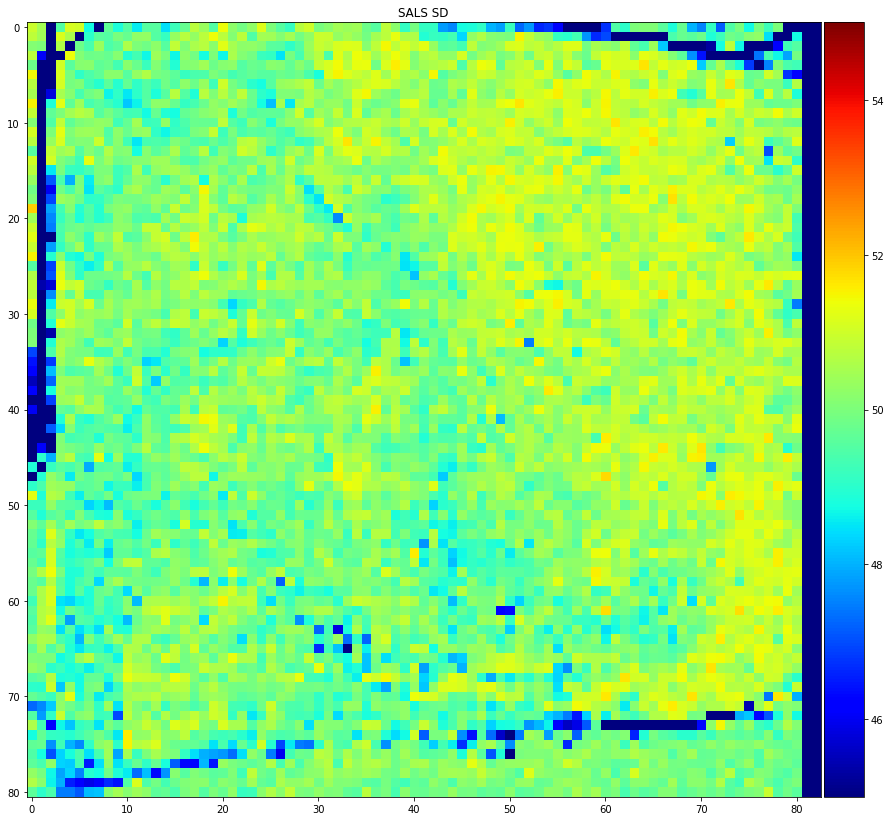

In [15]:
# SALS SD
fig = plt.figure(figsize=(15, 15))
im0 = plt.imshow(SD_2d, cmap='jet')
plt.title('SALS SD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (45, 55);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

## Register Images

### Create pSFDI Binary Mask

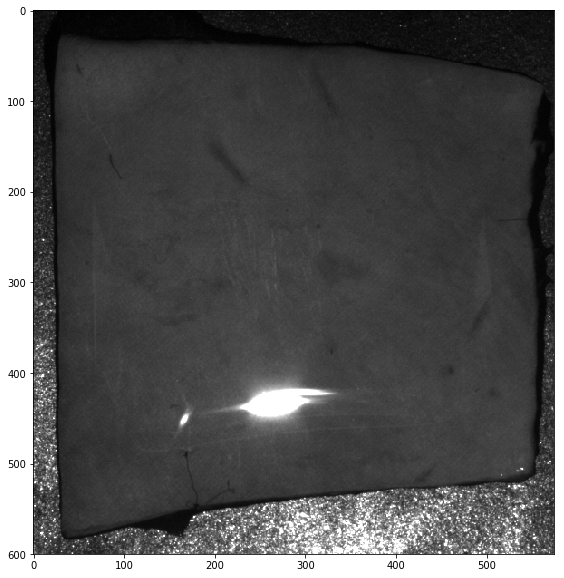

In [16]:
bp_planar_reg = bp_planar[0, :, :]
fig = plt.figure(figsize=(10, 10))
plt.imshow(bp_planar_reg, cmap='gray')
plt.imsave(os.path.join(bp_raw_path, 'cropped_for_mask.png'), bp_planar_reg, cmap='gray')

### View Binary Masks before upscaling

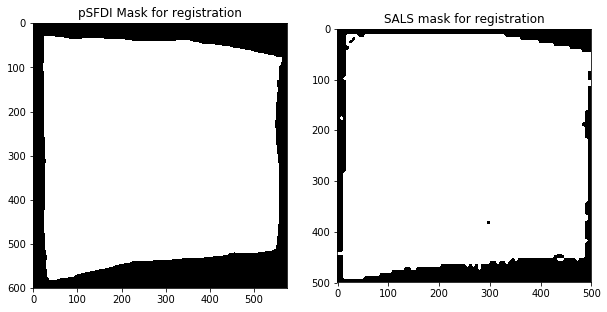

In [17]:
psfdi_mask = cv2.imread(os.path.join(bp_raw_path, 'Mask.tif'), -1)
if sys.platform == 'linux':
    sals_mask = cv2.imread(os.path.join(SALS_data_path, 'BW_Images/BP_ODF_42919.png'), -1)
else:
    sals_mask = cv2.imread(os.path.join(SALS_data_path, 'BW_Images\\BP_ODF_42919.png'), -1)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
im0 = ax0.imshow(psfdi_mask, cmap='gray');
ax0.set_title('pSFDI Mask for registration');

im1 = ax1.imshow(sals_mask, cmap='gray')
ax1.set_title('SALS mask for registration');

### Upscale Binary Masks

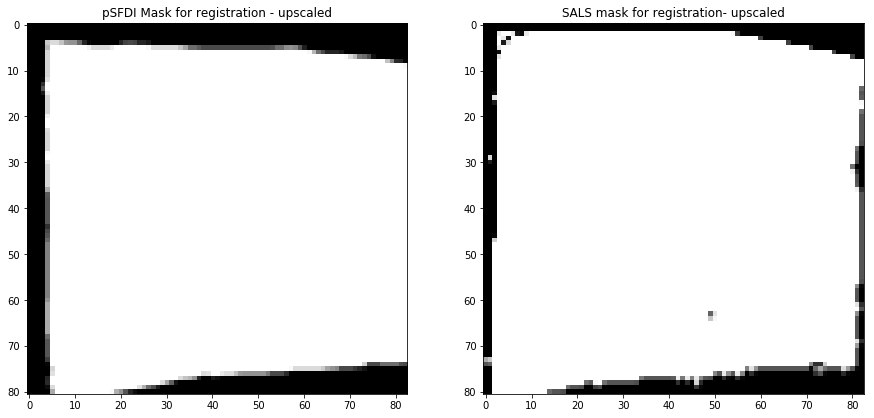

In [18]:
psfdi_mask_upscale = imp.upscale(psfdi_mask, *PD_2d.shape)
sals_mask_upscale = imp.upscale(sals_mask[:, :, 0], *PD_2d.shape)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
im0 = ax0.imshow(psfdi_mask_upscale, cmap='gray');
ax0.set_title('pSFDI Mask for registration - upscaled');

im1 = ax1.imshow(sals_mask_upscale, cmap='gray')
ax1.set_title('SALS mask for registration- upscaled');

### Register

In [19]:
# Register images
psfdi_mask_registered, warp_data = imp.register(psfdi_mask_upscale.astype(np.uint8), sals_mask_upscale.astype(np.uint8))

print('cc: {}'.format(warp_data['cc']))
print('warp matrix:')
print(warp_data['warp'])

cc: 0.9338341133234805
warp matrix:
[[ 0.9996186   0.0276161   0.14217685]
 [-0.0276161   0.9996186   2.7148695 ]]


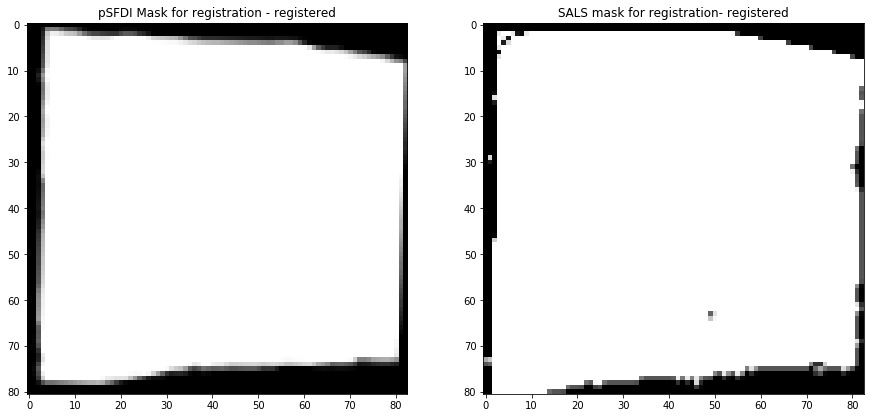

In [20]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
im0 = ax0.imshow(psfdi_mask_registered, cmap='gray');
ax0.set_title('pSFDI Mask for registration - registered');

im1 = ax1.imshow(sals_mask_upscale, cmap='gray')
ax1.set_title('SALS mask for registration- registered');

### Upscale and Register all the Planar pSFDI Data

In [21]:
# Upscale
bp_planar_upscale = [imp.upscale(bp_planar[angle, :, :], *PD_2d.shape) for angle in range(len(polar_angles))]
bp_planar_upscale = np.array(bp_planar_upscale)

In [22]:
# Register
bp_planar_registered = [imp.warp(bp_planar_upscale[angle, :, :], warp_data['warp']) for angle in range(len(polar_angles))]
bp_planar_registered = np.array(bp_planar_upscale)

## Feasibility Study - Raw Data

### Set the row and column data for visualization etc

In [23]:
row = 15
col = 15
ydim = SALS_data_dict['PD'].shape[0]

index = col * ydim + (ydim - col)

### Visualize where the point is

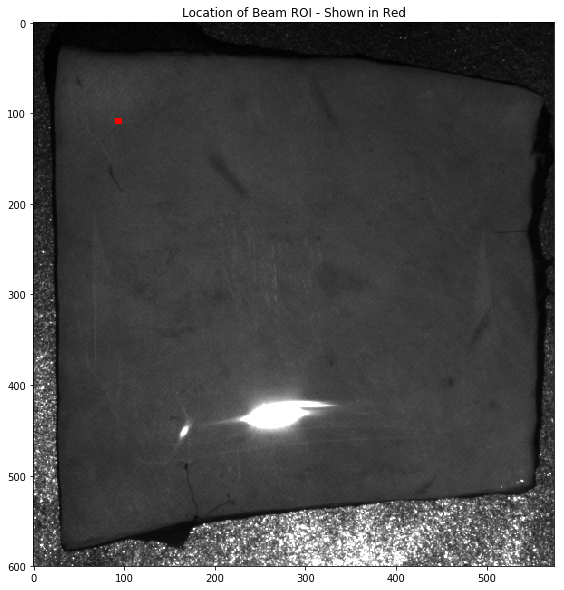

In [24]:
row_step = int(bp_planar.shape[1] / PD_2d.shape[0])
col_step = int(bp_planar.shape[2] / PD_2d.shape[1])

# Get the correct rectangle start indices
psfdi_row = row * row_step
psfdi_col = col * col_step

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(bp_planar[0, :, :], cmap='gray');
rect = patches.Rectangle((psfdi_col, psfdi_row), row_step, col_step, edgecolor='r', facecolor='r')
ax.add_patch(rect);
plt.title('Location of Beam ROI - Shown in Red');

### Get SALS data

In [25]:
odf_theta = SALS_data_dict['theta'][index, :]
odf_gamma = SALS_data_dict['odf'][index, :]

### Get pSFDI data with roll compensation

In [26]:
roll = 90 // polar_res

bp_data = bp_planar_registered[:, row, col]
bp_data = np.roll(bp_data, roll)

### Convert polar angles to radians for analysis

In [27]:
polar_angles = np.deg2rad(polar_angles)

### Visualize Data

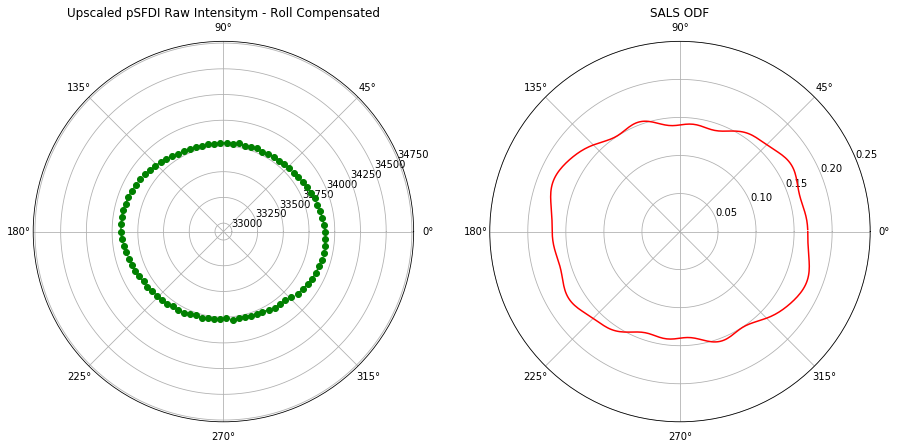

In [28]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15), subplot_kw=dict(projection='polar'))
ax0.plot(polar_angles, bp_data, linestyle='--', marker='o', color='g',
         label='Mean Fiber Intensity');
ax0.set_title('Upscaled pSFDI Raw Intensitym - Roll Compensated');
ax0.set_ylim([0.975 * np.min(bp_data), 1.025 * np.max(bp_data)])

ax1.plot(odf_theta, odf_gamma, color='r', label='SALS ODF');
ax1.set_ylim([0, 0.25])
ax1.set_title('SALS ODF');

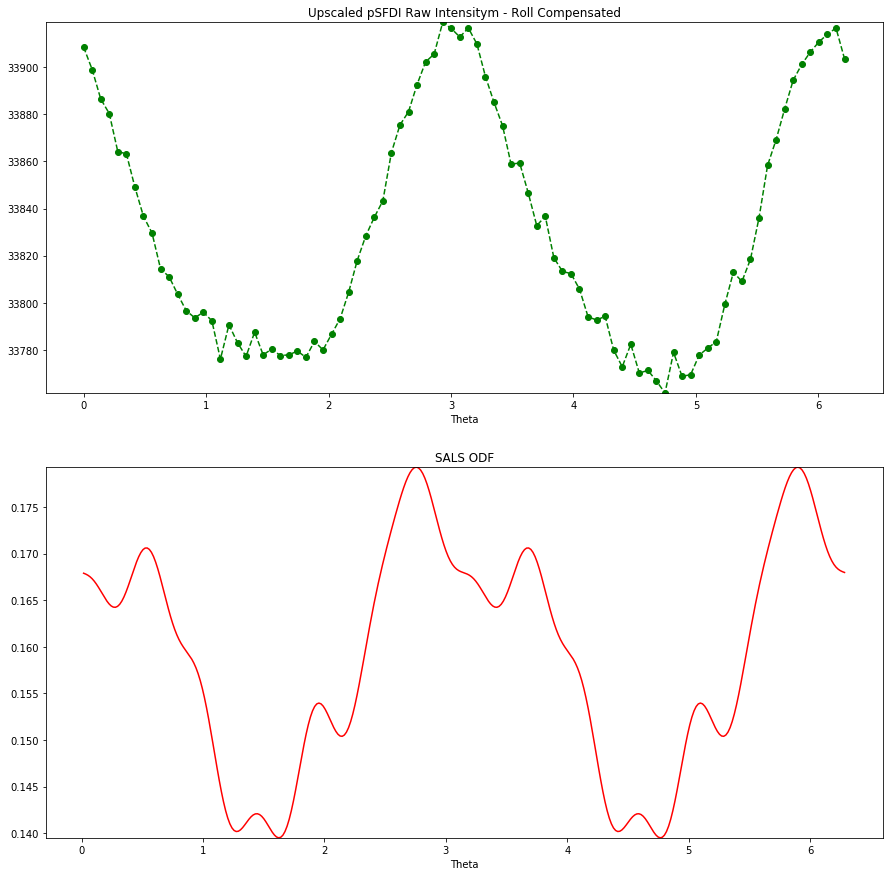

In [29]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 15))
ax0.plot(polar_angles, bp_data, linestyle='--', marker='o', color='g',
         label='Mean Fiber Intensity');
ax0.set_title('Upscaled pSFDI Raw Intensitym - Roll Compensated');
ax0.set_ylim([np.min(bp_data), np.max(bp_data)])
ax0.set_xlabel('Theta')

ax1.plot(odf_theta, odf_gamma, color='r', label='SALS ODF');
ax1.set_ylim([np.min(odf_gamma), np.max(odf_gamma)])
ax1.set_title('SALS ODF');
ax1.set_xlabel('Theta');

## Fourier Series Fit

### SALS Data

In [30]:
an, bn, c = odf.fit_fourier(20, odf_gamma, odf_theta)
odf_fsfit = odf.compute_fourier(an, bn, c, odf_theta)

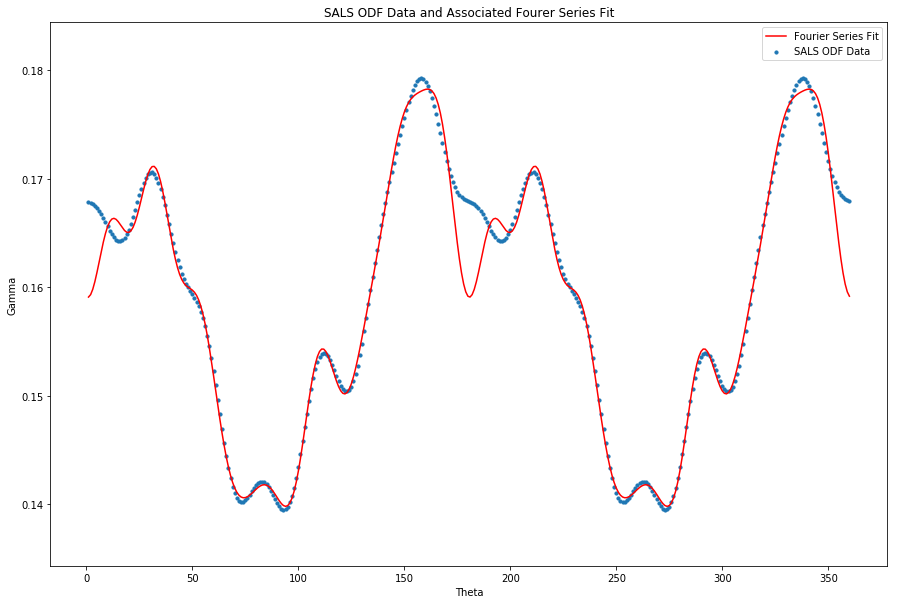

In [31]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(np.rad2deg(odf_theta), odf_gamma, marker='o', s=10, label='SALS ODF Data')
plt.plot(np.rad2deg(odf_theta), odf_fsfit, color='r', label='Fourier Series Fit');
plt.ylabel('Gamma');
plt.xlabel('Theta');
plt.legend()
plt.title('SALS ODF Data and Associated Fourer Series Fit');

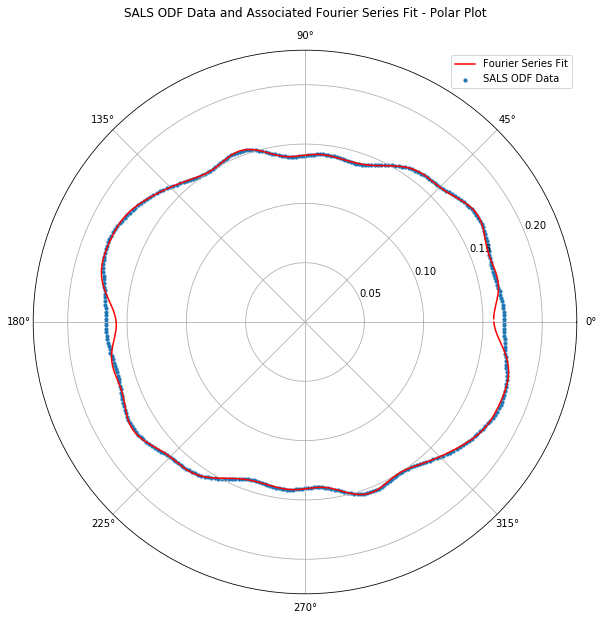

In [32]:
fig = plt.figure(figsize=(10, 10))
plt.polar(odf_theta, odf_fsfit, color='r', label='Fourier Series Fit');
plt.scatter(odf_theta, odf_gamma, s=10, label='SALS ODF Data');
plt.legend()
plt.title('SALS ODF Data and Associated Fourier Series Fit - Polar Plot');

## Compute the Primary and Secondary Directions

In [33]:
theta1, theta2 = odf.structural_eigenval_thetas(an[0], bn[0])

In [34]:
print('Theta I (deg): {}'.format(theta1))
print('Theta II (deg): {}'.format(theta2))

Theta I (deg): -4.388509209957466
Theta II (deg): 85.61149079004254


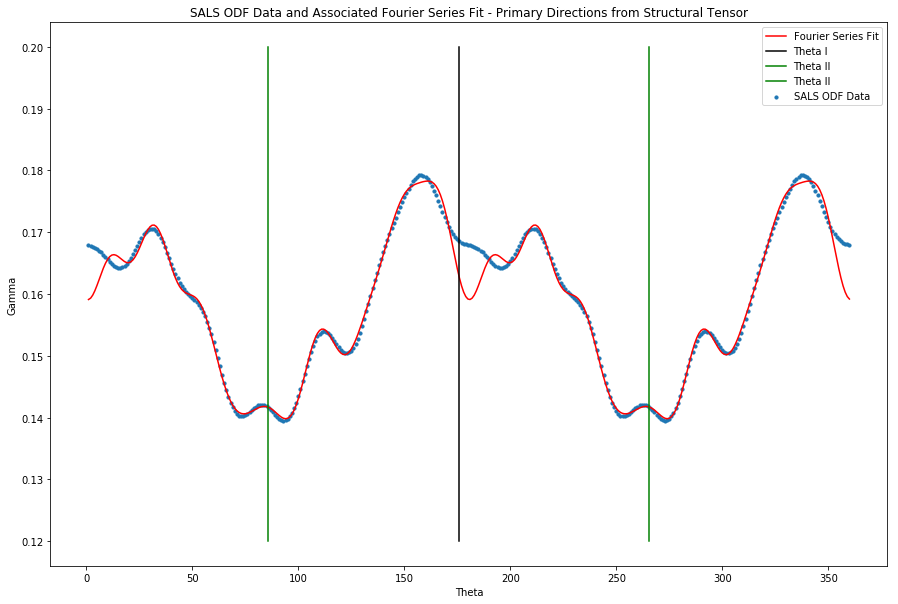

In [35]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(np.rad2deg(odf_theta), odf_gamma, s=10, label='SALS ODF Data');
plt.plot(np.rad2deg(odf_theta), odf_fsfit, color='r', label='Fourier Series Fit')
plt.plot((theta1 + 180) * np.ones(len(odf_theta)), np.linspace(0.12, 0.20, len(odf_theta)), color='k', label='Theta I')
plt.plot(theta2 * np.ones(len(odf_theta)), np.linspace(0.12, 0.20, len(odf_theta)), color='g', label='Theta II')
plt.plot((theta2 + 180) * np.ones(len(odf_theta)), np.linspace(0.12, 0.20, len(odf_theta)), color='g', label='Theta II')
plt.xlabel('Theta')
plt.ylabel('Gamma')
plt.legend();
plt.title('SALS ODF Data and Associated Fourier Series Fit - Primary Directions from Structural Tensor');

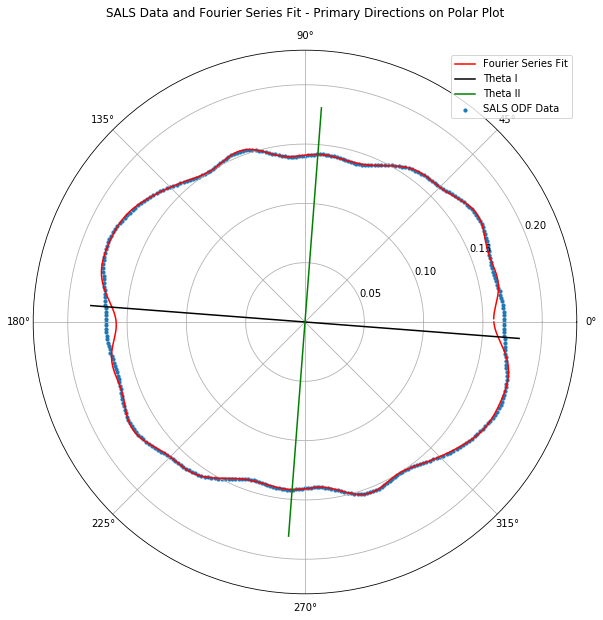

In [36]:
theta1_r = np.deg2rad(theta1)
theta2_r = np.deg2rad(theta2)
fig = plt.figure(figsize=(10, 10))
plt.polar(odf_theta, odf_fsfit, color='r', label='Fourier Series Fit');
plt.scatter(odf_theta, odf_gamma, s=10, label='SALS ODF Data');
plt.polar([theta1_r, theta1_r + np.pi], [1.01 * np.max(odf_gamma), 1.01 * np.max(odf_gamma)], color='k', label='Theta I')
plt.polar([theta2_r, theta2_r + np.pi], [1.01 * np.max(odf_gamma), 1.01 * np.max(odf_gamma)], color='g', label='Theta II')
plt.legend()
plt.title('SALS Data and Fourier Series Fit - Primary Directions on Polar Plot');

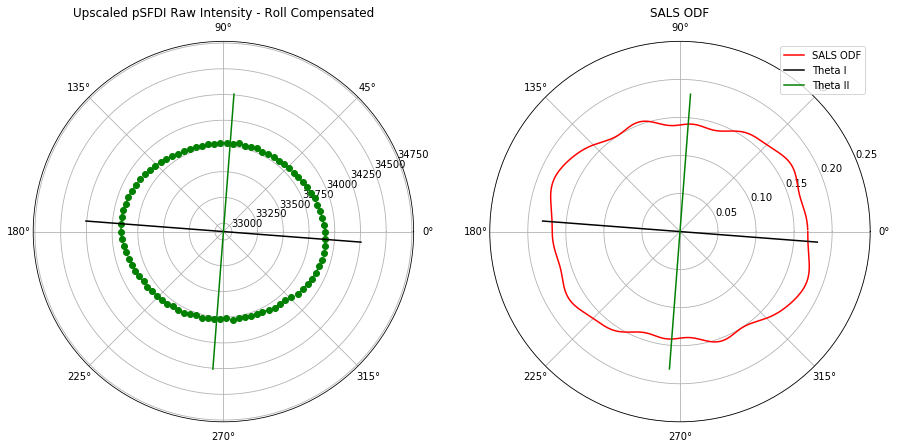

In [37]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15), subplot_kw=dict(projection='polar'))
ax0.plot(polar_angles, bp_data, linestyle='--', marker='o', color='g',
         label='Mean Fiber Intensity');
ax0.set_title('Upscaled pSFDI Raw Intensity - Roll Compensated');
ax0.set_ylim([0.975 * np.min(bp_data), 1.025 * np.max(bp_data)])
ax0.plot([theta1_r, theta1_r + np.pi], [1.01 * np.max(bp_data), 1.01 * np.max(bp_data)], color='k', label='Theta I')
ax0.plot([theta2_r, theta2_r + np.pi], [1.01 * np.max(bp_data), 1.01 * np.max(bp_data)], color='g', label='Theta II')

ax1.plot(odf_theta, odf_gamma, color='r', label='SALS ODF');
ax1.plot([theta1_r, theta1_r + np.pi], [1.01 * np.max(odf_gamma), 1.01 * np.max(odf_gamma)], color='k', label='Theta I')
ax1.plot([theta2_r, theta2_r + np.pi], [1.01 * np.max(odf_gamma), 1.01 * np.max(odf_gamma)], color='g', label='Theta II')
ax1.set_ylim([0, 0.25])
ax1.set_title('SALS ODF');
plt.legend();

## SALS Data: Remove Pi-Spans & Double Check Normalization

### Pi-Spans

In [38]:
lower = odf_theta > np.deg2rad(theta2) 
upper = odf_theta < np.deg2rad(theta2 + 180)
indices1 = np.all((lower, upper), axis=0)

indices2 = np.array(list(range(np.max(np.where(upper)) + 1, len(odf_theta))))
indices2 = np.append(indices2, np.array(list(range(np.min(np.where(lower))))))

In [61]:
theta_pi_span1 = odf_theta[indices1]
# Shift this to 0 deg
theta_pi_span1 = theta_pi_span1 - np.min(theta_pi_span1)
# Shift this to -pi/2
theta_pi_span1 = theta_pi_span1 - np.pi / 2
gamma_pi_span1 = odf_gamma[indices1]

theta_pi_span2 = odf_theta[indices2]
theta_pi_span2 = theta_pi_span2 - np.min(theta_pi_span2)
jump_start = np.argmax(np.abs(np.diff(theta_pi_span2))) + 1
jump = np.max(np.abs(np.diff(theta_pi_span2)))
theta_pi_span2[:jump_start] = theta_pi_span2[:jump_start] - jump
theta_pi_span2 = theta_pi_span2 + (-np.pi / 2 - np.min(theta_pi_span2))
gamma_pi_span2 = odf_gamma[indices2]

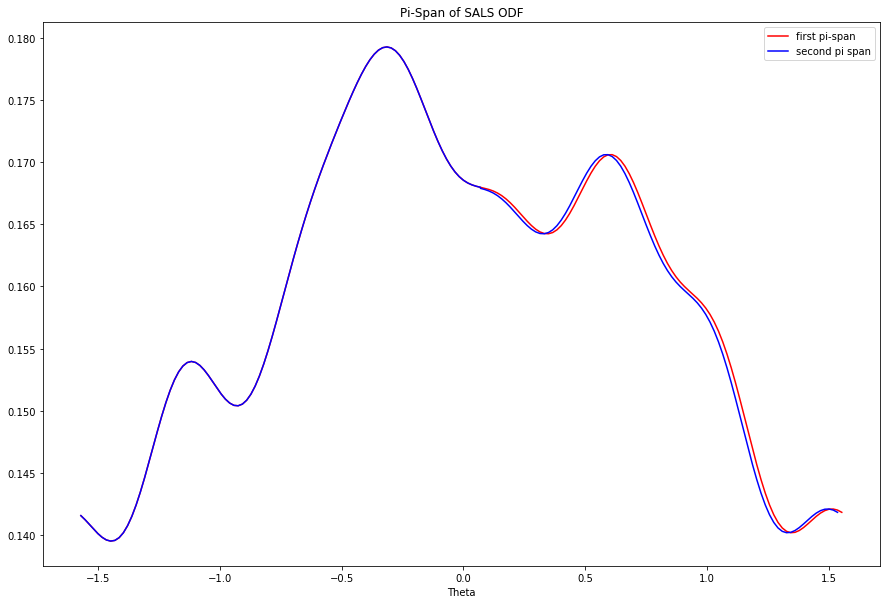

In [66]:
fig = plt.figure(figsize=(15, 10))
plt.plot(theta_pi_span1, gamma_pi_span1, color='r', label='first pi-span');
plt.plot(theta_pi_span2, gamma_pi_span2, color='b', label='second pi span')
plt.title('Pi-Spans of SALS ODF');
plt.xlabel('Theta');
plt.legend();

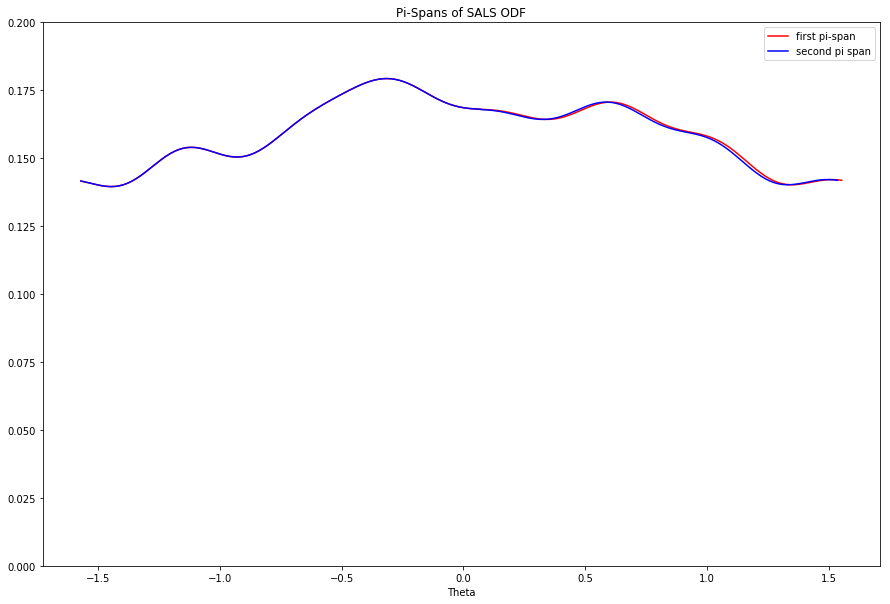

In [67]:
fig = plt.figure(figsize=(15, 10))
plt.plot(theta_pi_span1, gamma_pi_span1, color='r', label='first pi-span');
plt.plot(theta_pi_span2, gamma_pi_span2, color='b', label='second pi span')
plt.title('Pi-Spans of SALS ODF');
plt.ylim([0, 0.2])
plt.xlabel('Theta');
plt.legend();

### Area normalization

In [68]:
gamma_area = trapz(odf_gamma, odf_theta)
print('Area under ODF: {}'.format(gamma_area))

Area under ODF: 0.9970688224045


## Compute Mean and SD of SALS Pi-Spans

In [72]:
gamma_mean1 = trapz(theta_pi_span1 * gamma_pi_span1, theta_pi_span1)
gamma_var1 = trapz(gamma_pi_span1 * np.square(theta_pi_span1 - gamma_mean1), theta_pi_span1)
gamma_sd1 = np.sqrt(gamma_var1)

gamma_mean2 = trapz(theta_pi_span2 * gamma_pi_span2, theta_pi_span2)
gamma_var2 = trapz(gamma_pi_span2 * np.square(theta_pi_span2 - gamma_mean2), theta_pi_span2)
gamma_sd2 = np.sqrt(gamma_var2)

In [74]:
print('Mean of First Pi-Span (deg): {}'.format(np.rad2deg(gamma_mean1)))
print('Standard Deviation of First Pi-Span (deg): {}'.format(np.rad2deg(gamma_sd1)))
print('')
print('Mean of Second Pi-Span (deg): {}'.format(np.rad2deg(gamma_mean2)))
print('Standard Deviation of Second Pi-Span (deg): {}'.format(np.rad2deg(gamma_sd2)))

Mean of First Pi-Span (deg): -0.20235928102783937
Standard Deviation of First Pi-Span (deg): 35.28874307686975

Mean of Second Pi-Span (deg): -0.4473192755181899
Standard Deviation of Second Pi-Span (deg): 34.987329949527705


### Compute beta distribution

In [ ]:
# Compute the beta values
sals_beta = odf.compute_beta(gamma_mean, gamma_sd, theta_pi_span)

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(theta_pi_span,sals_beta, color='k', label='Beta Distribution');
plt.plot(theta_pi_span, norm_gamma_pi_span, color='r', label='SALS ODF')
plt.title('SALS ODF and Beta Distribution');
plt.xlabel('Theta')
plt.legend();

## Wrapped Normal Distribution

In [ ]:
test_wn = odf.wrapped_normal(gamma_mean, gamma_sd, np.pi, theta_pi_span)
fig = plt.figure(figsize=(10, 10))
plt.plot(theta_pi_span, test_wn);

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(theta_pi_span, test_wn, color='k', label='Wrapped Normal Distribution');
plt.plot(theta_pi_span, norm_gamma_pi_span, color='r', label='SALS ODF')
plt.title('SALS ODF and Beta Distribution');
plt.xlabel('Theta')
plt.legend();

# Extracting Single Fiber Values Using Continous Convolution

## Use wrapped normal distribution

In [ ]:
test_wn = odf.wrapped_normal(gamma_mean, gamma_sd, np.pi, theta_pi_span)
fig = plt.figure(figsize=(10, 10))
plt.plot(theta_pi_span, test_wn);
plt.title('Wrapped Normal Distribution with Mean and Std. Dev from SALS Data');

## Test out the Continous Convolution

### Single Fiber

In [ ]:
a0test, a2test, a4test, = 0.3, 0.01, 0.01
radThetas = np.linspace(-np.pi / 2, np.pi / 2, 180)
testI = odf.IfiberRad(a0test, a2test, a4test, gamma_mean, radThetas)

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, testI)
plt.title('Test I Single Fiber');

### Fiber Distributions

In [ ]:
testIdist = odf.IdistWrappedNormal(a0test, a2test, a4test, gamma_mean, radThetas, test_wn)
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, testI, label='Single Fiber')
plt.plot(radThetas, testIdist, label='Fiber Distribution')
plt.legend();

### Test minimization

In [ ]:
test_data = np.column_stack((radThetas, testIdist))
args = (gamma_mean, radThetas, test_wn, test_data)
int_x = np.array([0, 0, 0])
bounds = ((0, 1), (-1, 1), (0, 1))
minfun = odf.minfunWrappedNormal
res = sciopt.minimize(minfun, int_x, args=args, bounds=bounds, method='L-BFGS-B')
print('Final values of a0, a2, a4: {}'.format(res.x))
print('Synthetic values of a0, a2, a4: {}'.format(np.array([a0test, a2test, a4test])))
print('Final residual: {}'.format(res.fun))
print('Final optimizer success status: {}'.format(res.success))
print('Final optimizer message: {}'.format(res.message))

### Plot Test Minimization Results

In [ ]:
fitFiber = odf.IfiberRad(res.x[0], res.x[1], res.x[2], gamma_mean, radThetas)
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, testI, label='Synthetic Single Fiber')
plt.plot(radThetas, fitFiber, marker='o', label='Fit Single Fiber')
plt.legend();

## Fit pSFDI Data

### Prep for minimizing

In [ ]:
psfdi_wn = odf.wrapped_normal(gamma_mean, gamma_sd, np.pi, psfdi_theta_pi_span)
psfdi_data = np.column_stack((psfdi_theta_pi_span, norm_intensity_pi_span))
args = (gamma_mean, psfdi_theta_pi_span, psfdi_wn, psfdi_data)
int_x = np.array([0, 0, 0])  # Good enough to guess all zeros
bounds = ((0, 1), (-1, 1), (0, 1))

### Minimize and report results

In [ ]:
minfun = odf.minfunWrappedNormal
res = sciopt.minimize(minfun, int_x, args=args, bounds=bounds, method='L-BFGS-B')
print('Final values of a0, a2, a4: {}'.format(res.x))
print('Final residual: {}'.format(res.fun))
print('Final optimizer success status: {}'.format(res.success))
print('Final optimizer message: {}'.format(res.message))

### Plot resulting fit

In [ ]:
a0_fit_wn = res.x[0]
a2_fit_wn = res.x[1]
a4_fit_wn = res.x[2]

fit_Idist_wn = odf.IdistWrappedNormal(a0_fit_wn, a2_fit_wn, a4_fit_wn, gamma_mean, psfdi_theta_pi_span, psfdi_wn)

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(psfdi_theta_pi_span, norm_intensity_pi_span, color='g', label='Raw Intensity Data')
plt.plot(psfdi_theta_pi_span, fit_Idist_wn, color='k', label='Distribution Signal from Fit Single Fiber Terms');
plt.ylim([0.999 * np.min(norm_intensity_pi_span), 1.001 * np.max(norm_intensity_pi_span)]);
plt.title('Single Fiber ai terms run through wn vs. Raw Intensity Data');
plt.xlabel('Theta');
plt.legend();

# Extracting Distribution Statistics

## Test out Continous Convolution

### Single Fiber

In [ ]:
a0test, a2test, a4test, = 0.3, 0.01, 0.01
radThetas = np.linspace(-np.pi / 2, np.pi / 2, 180)
testI = odf.IfiberRad(a0test, a2test, a4test, gamma_mean, radThetas)
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, testI)
plt.title('Test I Single Fiber');

### Fiber Distributions

In [ ]:
testIdist = odf.IdistWrappedNormal(a0test, a2test, a4test, gamma_mean, radThetas, test_wn)
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, testI, label='Single Fiber')
plt.plot(radThetas, testIdist, label='Fiber Distribution')
plt.legend();

### Test minfun

In [ ]:
test_data = np.column_stack((radThetas, testIdist))
args = (a0test, a2test, a4test, gamma_mean, radThetas, test_data)
test_params = [gamma_mean, gamma_sd]
odf.minfunWrappedNormalODF(test_params, *args)

### Test Minimization

In [ ]:
int_x = np.array([0, 0])
bounds = ((-np.pi / 2, np.pi / 2), (np.pi / 15, np.pi))
minfun = odf.minfunWrappedNormalODF
res = sciopt.minimize(minfun, int_x, args=args, bounds=bounds, method='L-BFGS-B')
print('Final values of mean, standard deviation: {}'.format(np.rad2deg(res.x)))
print('Synthetic values of mean, standard deviation from SALS: {}'.format(np.rad2deg(np.array([gamma_mean, gamma_sd]))))
print('Final residual: {}'.format(res.fun))
print('Final optimizer success status: {}'.format(res.success))
print('Final optimizer message: {}'.format(res.message))

In [ ]:
fit_dist = odf.wrapped_normal(res.x[0], res.x[1], np.pi, radThetas)
fitFiberDist = odf.IdistWrappedNormal(a0test, a2test, a4test, gamma_mean, radThetas, fit_dist)
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, testIdist, label='Synthetic Fiber Distribution Signal')
plt.plot(radThetas, fitFiberDist, marker='o', label='Fit Fiber Distribution Signal')
plt.legend();

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, test_wn, label='Wrapped Normal using SALS mean/stddev');
plt.plot(radThetas, fit_dist, label='Wrapped Normal using fit mean/stddev');
plt.legend();

## Try the pSFDI Data

### Global

In [ ]:
psfdi_data = np.column_stack((psfdi_theta_pi_span, norm_intensity_pi_span))
args = (a0_fit_wn, a2_fit_wn, a4_fit_wn, gamma_mean, psfdi_theta_pi_span, psfdi_data)
bounds = ((-np.pi / 2, np.pi / 2), (np.pi / 15, np.pi))
minfun = odf.minfunWrappedNormalODF
res = sciopt.differential_evolution(minfun, args=args, bounds=bounds)
print('Final values of mean, standard deviation: {}'.format(np.rad2deg(res.x)))
print('SALS values of mean, standard deviation: {}'.format(np.rad2deg(np.array([gamma_mean, gamma_sd]))))
print('Final residual: {}'.format(res.fun))
print('Final optimizer success status: {}'.format(res.success))
print('Final optimizer message: {}'.format(res.message))

In [ ]:
fit_dist = odf.wrapped_normal(res.x[0], res.x[1], np.pi, psfdi_theta_pi_span)
fitFiberDist = odf.IdistWrappedNormal(a0_fit_wn, a2_fit_wn, a4_fit_wn, gamma_mean, psfdi_theta_pi_span, fit_dist)
fig = plt.figure(figsize=(10, 10))
plt.scatter(psfdi_theta_pi_span, norm_intensity_pi_span, color='g', label='Raw Intensity Data')
plt.plot(psfdi_theta_pi_span, fitFiberDist, color='k', label='Distribution Signal from Fit Single Fiber Terms and Fit Distribution');
plt.ylim([0.999 * np.min(norm_intensity_pi_span), 1.001 * np.max(norm_intensity_pi_span)]);
plt.title('Single Fiber ai terms run through fit wn vs. Raw Intensity Data');
plt.xlabel('Theta');
plt.legend();

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, test_wn, label='Wrapped Normal using SALS mean/stddev');
plt.plot(psfdi_theta_pi_span, fit_dist, label='Wrapped Normal using fit mean/stddev');
plt.legend();

# Fit Both Distribution Statistics and Fiber Terms in One Shot


## Have the single fiber PD be fixed by gamma mean

## Test on Synthetic Data

In [ ]:
a0test, a2test, a4test, = 0.3, 0.01, 0.01
radThetas = np.linspace(-np.pi / 2, np.pi / 2, 180)
testI = odf.IfiberRad(a0test, a2test, a4test, gamma_mean, radThetas)
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, testI)
plt.title('Test I Single Fiber');

In [ ]:
testIdist = odf.IdistWrappedNormal(a0test, a2test, a4test, gamma_mean, radThetas, test_wn)
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, testI, label='Single Fiber')
plt.plot(radThetas, testIdist, label='Fiber Distribution')
plt.legend();

In [ ]:
if sys.platform == 'linux':
    workernum = 18
else:
    workernum = 1
test_data = np.column_stack((radThetas, testIdist))
args = (gamma_mean, radThetas, test_data)
bounds = ((-np.pi / 2, np.pi / 2), (np.pi / 15, np.pi), (0, 1), (-1, 1), (0, 1))
minfun = odf.minfunWrappedNormalComposite
res = sciopt.differential_evolution(minfun, args=args, bounds=bounds, workers=workernum)
print('Final values of mean, standard deviation: {}'.format(np.rad2deg(res.x[:2])))
print('SALS values of mean, standard deviation: {}'.format(np.rad2deg(np.array([gamma_mean, gamma_sd]))))
print('Final values of a0, a2, a4: {}'.format(res.x[2:]))
print('Synthetic values of a0, a2, a4 : {}'.format(np.array([a0test, a2test, a4test])))
print('Final residual: {}'.format(res.fun))
print('Final optimizer success status: {}'.format(res.success))
print('Final optimizer message: {}'.format(res.message))

In [ ]:
fit_dist = odf.wrapped_normal(res.x[0], res.x[1], np.pi, radThetas)
fitFiberDist = odf.IdistWrappedNormal(res.x[2], res.x[3], res.x[4], gamma_mean, radThetas, fit_dist)
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, testIdist, label='Synthetic Fiber Distribution Signal')
plt.plot(radThetas, fitFiberDist, marker='o', label='Fit Fiber Distribution Signal')
plt.legend();

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, test_wn, label='Wrapped Normal using SALS mean/stddev');
plt.plot(radThetas, fit_dist, label='Wrapped Normal using fit mean/stddev');
plt.legend();

## Try pSFDI Data

In [ ]:
if sys.platform == 'linux':
    workernum = 18
else:
    workernum = 1
psfdi_data = np.column_stack((psfdi_theta_pi_span, norm_intensity_pi_span))
args = (gamma_mean, psfdi_theta_pi_span, psfdi_data)
bounds = ((-np.pi / 2, np.pi / 2), (np.pi / 15, np.pi), (0, 1), (-1, 1), (0, 1))
minfun = odf.minfunWrappedNormalComposite
res = sciopt.differential_evolution(minfun, args=args, bounds=bounds, workers=workernum)
print('Final values of mean, standard deviation: {}'.format(np.rad2deg(res.x[:2])))
print('SALS values of mean, standard deviation: {}'.format(np.rad2deg(np.array([gamma_mean, gamma_sd]))))
print('Final values of a0, a2, a4: {}'.format(res.x[2:]))
print('Values of a0, a2, a4 from fitting just single fiber with SALS ODF data: {}'.format(np.array([a0_fit_wn, a2_fit_wn, a4_fit_wn])))
print('Final residual: {}'.format(res.fun))
print('Final optimizer success status: {}'.format(res.success))
print('Final optimizer message: {}'.format(res.message))

In [ ]:
fit_dist = odf.wrapped_normal(res.x[0], res.x[1], np.pi, psfdi_theta_pi_span)
fitFiberDist = odf.IdistWrappedNormal(res.x[2], res.x[3], res.x[4], gamma_mean, psfdi_theta_pi_span, fit_dist)
fig = plt.figure(figsize=(10, 10))
plt.scatter(psfdi_theta_pi_span, norm_intensity_pi_span, color='g', label='Raw Intensity Data')
plt.plot(psfdi_theta_pi_span, fitFiberDist, color='k', label='Distribution Signal from Simultaneously Fit Single Fiber Terms and Fit Distribution');
plt.ylim([0.999 * np.min(norm_intensity_pi_span), 1.001 * np.max(norm_intensity_pi_span)]);
plt.title('Fit Single Fiber ai Terms with Fit WN mean/standard dev vs. Raw Intensity Data');
plt.xlabel('Theta');
plt.legend();

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, test_wn, label='Wrapped Normal using SALS mean/stddev');
plt.plot(psfdi_theta_pi_span, fit_dist, label='Wrapped Normal using fit mean/stddev');
plt.legend();

## Let single fiber PD be a free variable

## Test on synthetic data

In [ ]:
a0test, a2test, a4test, = 0.3, 0.01, 0.01
radThetas = np.linspace(-np.pi / 2, np.pi / 2, 180)
testI = odf.IfiberRad(a0test, a2test, a4test, gamma_mean, radThetas)
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, testI)
plt.title('Test I Single Fiber');

In [ ]:
testIdist = odf.IdistWrappedNormal(a0test, a2test, a4test, gamma_mean, radThetas, test_wn)
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, testI, label='Single Fiber')
plt.plot(radThetas, testIdist, label='Fiber Distribution')
plt.legend();

In [ ]:
if sys.platform == 'linux':
    workernum = 18
else:
    workernum = 1
test_data = np.column_stack((radThetas, testIdist))
args = (radThetas, test_data)
bounds = ((-np.pi / 2, np.pi / 2), (np.pi / 15, np.pi), (0, 1), (-1, 1), (0, 1), (-np.pi / 2, np.pi / 2))
minfun = odf.minfunWrappedNormalCompositePhi
res = sciopt.differential_evolution(minfun, args=args, bounds=bounds, workers=workernum)
print('Final values of mean, standard deviation: {}'.format(np.rad2deg(res.x[:2])))
print('SALS values of mean, standard deviation: {}'.format(np.rad2deg(np.array([gamma_mean, gamma_sd]))))
print('Final values of a0, a2, a4, phi: {}'.format(res.x[2:]))
print('Synthetic values of a0, a2, a4, phi : {}'.format(np.array([a0test, a2test, a4test, gamma_mean])))
print('Final residual: {}'.format(res.fun))
print('Final optimizer success status: {}'.format(res.success))
print('Final optimizer message: {}'.format(res.message))

In [ ]:
fit_dist = odf.wrapped_normal(res.x[0], res.x[1], np.pi, radThetas)
fitFiberDist = odf.IdistWrappedNormal(res.x[2], res.x[3], res.x[4], res.x[5], radThetas, fit_dist)
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, testIdist, label='Synthetic Fiber Distribution Signal')
plt.plot(radThetas, fitFiberDist, marker='o', label='Fit Fiber Distribution Signal')
plt.legend();

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, test_wn, label='Wrapped Normal using SALS mean/stddev');
plt.plot(radThetas, fit_dist, label='Wrapped Normal using fit mean/stddev');
plt.legend();

## Try pSFDI Data

In [ ]:
if sys.platform == 'linux':
    workernum = 18
else:
    workernum = 1
psfdi_data = np.column_stack((psfdi_theta_pi_span, norm_intensity_pi_span))
args = (psfdi_theta_pi_span, psfdi_data)
bounds = ((-np.pi / 2, np.pi / 2), (np.pi / 15, np.pi), (0, 1), (-1, 1), (0, 1), (-np.pi / 2, np.pi / 2))
minfun = odf.minfunWrappedNormalCompositePhi
res = sciopt.differential_evolution(minfun, args=args, bounds=bounds, workers=workernum)
print('Final values of mean, standard deviation: {}'.format(np.rad2deg(res.x[:2])))
print('SALS values of mean, standard deviation: {}'.format(np.rad2deg(np.array([gamma_mean, gamma_sd]))))
print('Final values of a0, a2, a4, phi: {}'.format(res.x[2:]))
print('Values of a0, a2, a4, phi from fitting just single fiber with SALS ODF data: {}'.format(np.array([a0_fit_wn, a2_fit_wn, a4_fit_wn, gamma_mean])))
print('Final residual: {}'.format(res.fun))
print('Final optimizer success status: {}'.format(res.success))
print('Final optimizer message: {}'.format(res.message))

In [ ]:
fit_dist = odf.wrapped_normal(res.x[0], res.x[1], np.pi, psfdi_theta_pi_span)
fitFiberDist = odf.IdistWrappedNormal(res.x[2], res.x[3], res.x[4], res.x[5], psfdi_theta_pi_span, fit_dist)
fig = plt.figure(figsize=(10, 10))
plt.scatter(psfdi_theta_pi_span, norm_intensity_pi_span, color='g', label='Raw Intensity Data')
plt.plot(psfdi_theta_pi_span, fitFiberDist, color='k', label='Distribution Signal from Simultaneously Fit Single Fiber Terms and Fit Distribution');
plt.ylim([0.999 * np.min(norm_intensity_pi_span), 1.001 * np.max(norm_intensity_pi_span)]);
plt.title('Fit Single Fiber ai Terms with Fit WN mean/standard dev vs. Raw Intensity Data');
plt.xlabel('Theta');
plt.legend();

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.plot(radThetas, test_wn, label='Wrapped Normal using SALS mean/stddev');
plt.plot(psfdi_theta_pi_span, fit_dist, label='Wrapped Normal using fit mean/stddev');
plt.legend();